# Chap03 - MCMC 블랙박스 열기

## 3.1 베이지안 지형

베이지안 추론을 위해서는 **MCMC(Markov Chain Monte Carlo)**를 다루어야만 한다. MCMC과정을 알면 알고리즘의 수렴 여부를 알 수 있다. 또한, 우리가 1, 2장에서 살펴보았던 모델링 후 수천 개의 사후확률표본을 돌려받는 이유를 이해할 수 있다.

미지수가 $N$개인 베이지안 추론 문제를 설정할 때 암묵적으로 기존에 있는 사전확률분포를 위한 $N$차원 공간을 만든다. 공간과 관련된 것이 추가 차원인데, **표면**(surface) 또는 **곡선**(curve)라고 하며, 특정한 위치의 **사전확률을**을 반영하는 공간의 상단(?)을 말한다. 공간 위 표면은 사전확률분포로 정의된다. 

예를 들어 미지수 $p_1$과 $p_2$가 있고 둘의 사전확률분포가 $\text{Uniform}(0,5)$라면 만들어진 공간은 한 변의 길이가 $5$인 정사각형이고 표면은 그 정사각형이고 표면은 그 정사각형 위에 있는 평면이다. 여기서 균등 사전확률분포를 선택했기 때문에 모든 점의 확률이 같음을 나타낸다.

In [6]:
%matplotlib inline 
import numpy as np
import matplotlib
import scipy.stats as stats

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', family='NanumGothic')  # linux

figsize(12, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

Text(0.5,0.92,'균등 사전확률분포로 구성한 다른 방향의 모습')

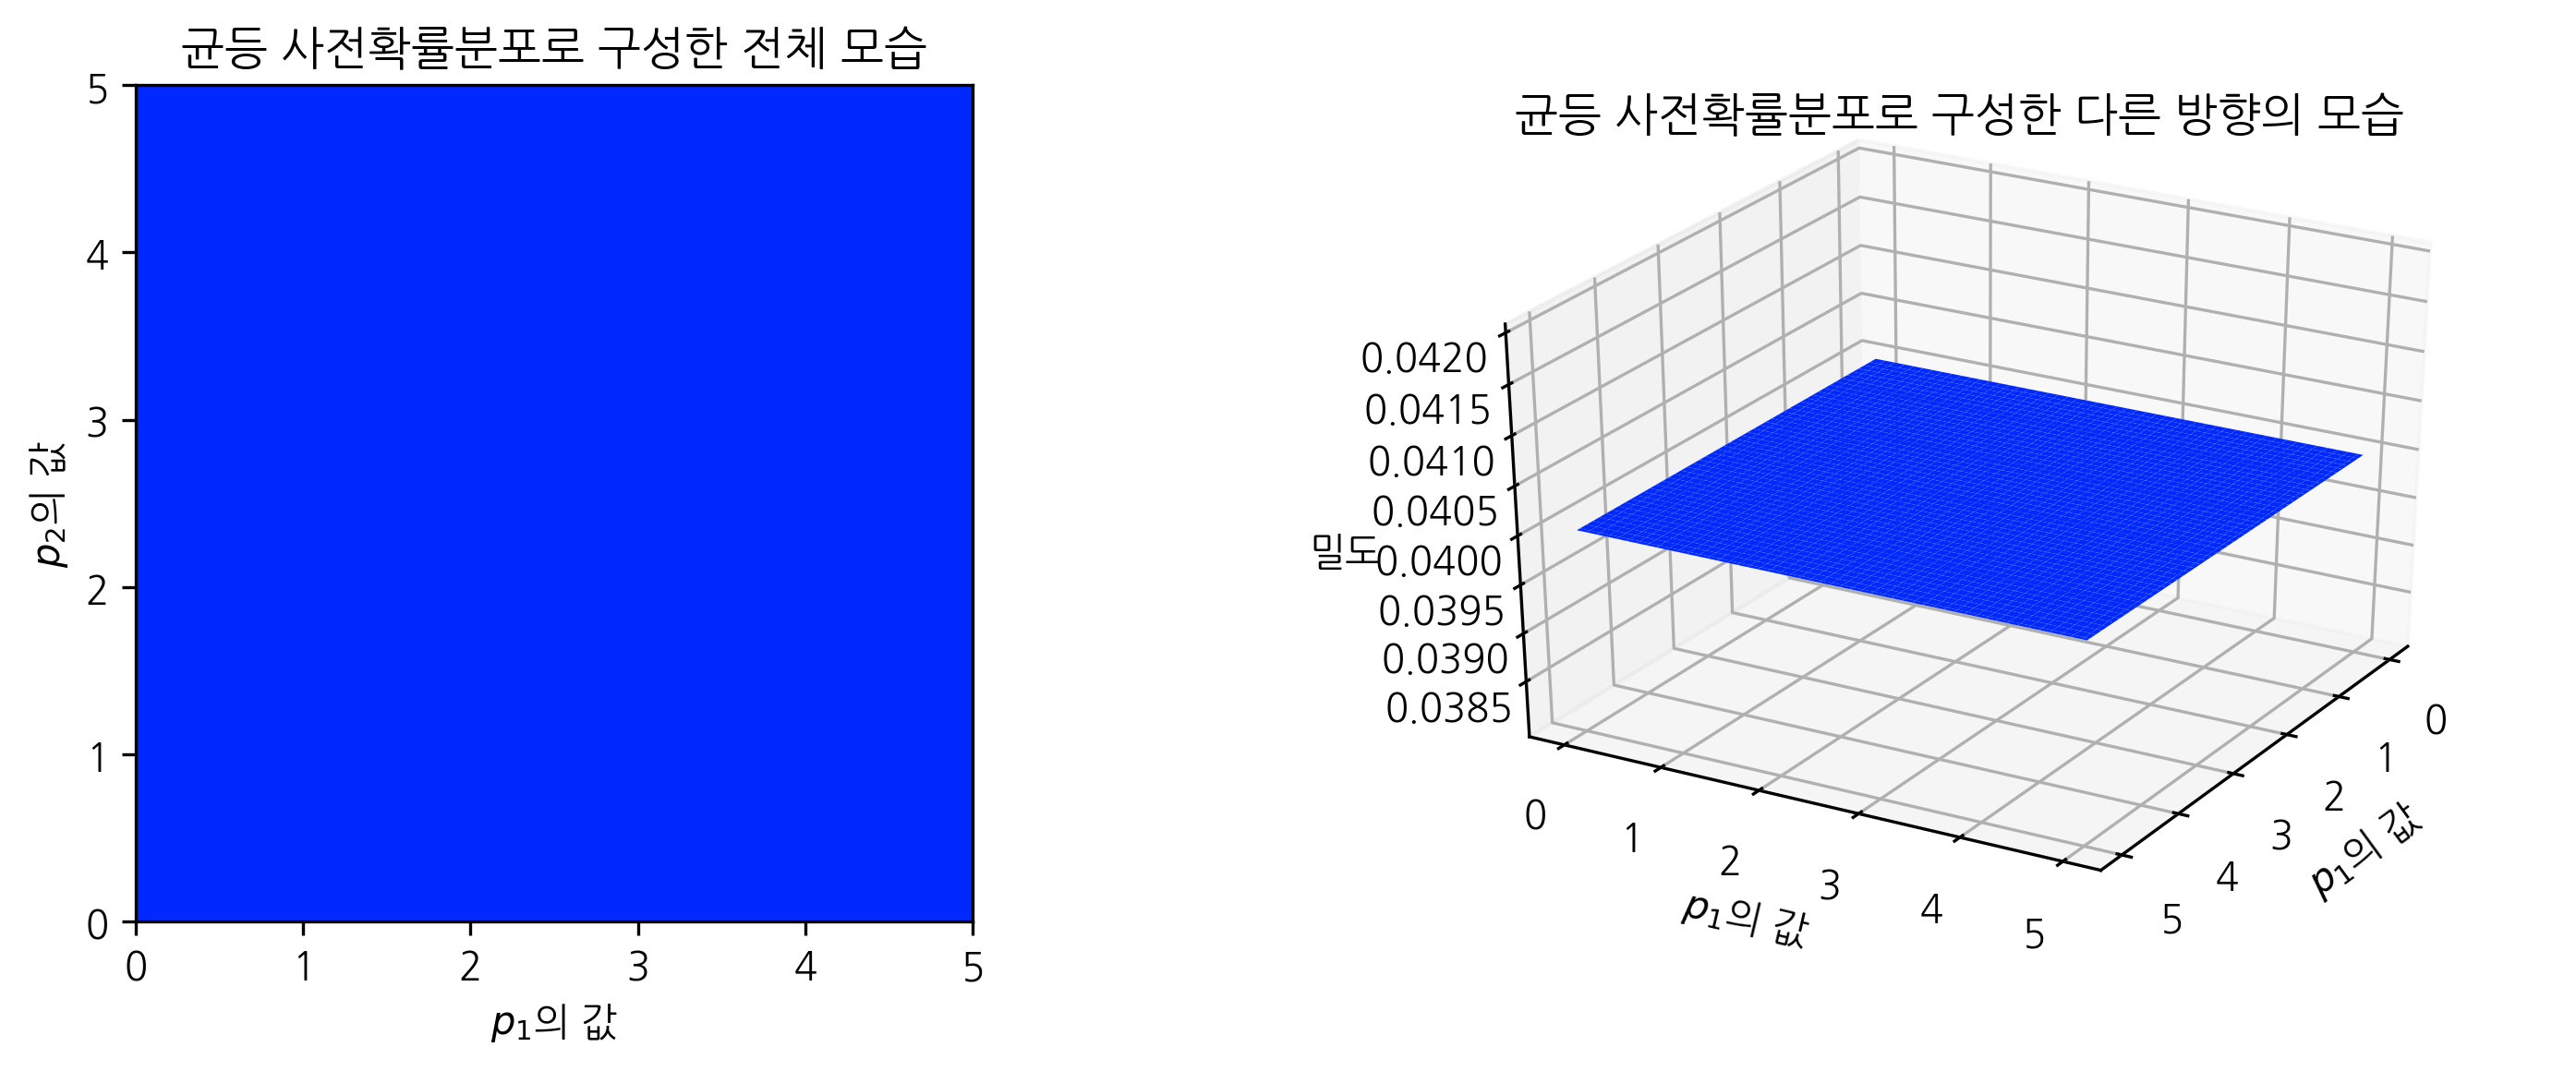

In [8]:
jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('$p_1$의 값')
plt.ylabel('$p_2$의 값')
plt.title('균등 사전확률분포로 구성한 전체 모습')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
ax.set_xlabel('$p_1$의 값')
ax.set_ylabel('$p_1$의 값')
ax.set_zlabel('밀도')
plt.title('균등 사전확률분포로 구성한 다른 방향의 모습')

만약, 두 사전확률분포가 $\text{Exp}(3)$과 $\text{Exp}(10)$이라면 공간은 2차원 평면에서 모두 양수다. 아래의 그림은 색상이 어두운 빨간색일수록 그 위치에 더 많은 사전확률이 할당된 것이다. 어두운 파란색일수록 그 위치에 할당된 사전확률은 매우 작다.

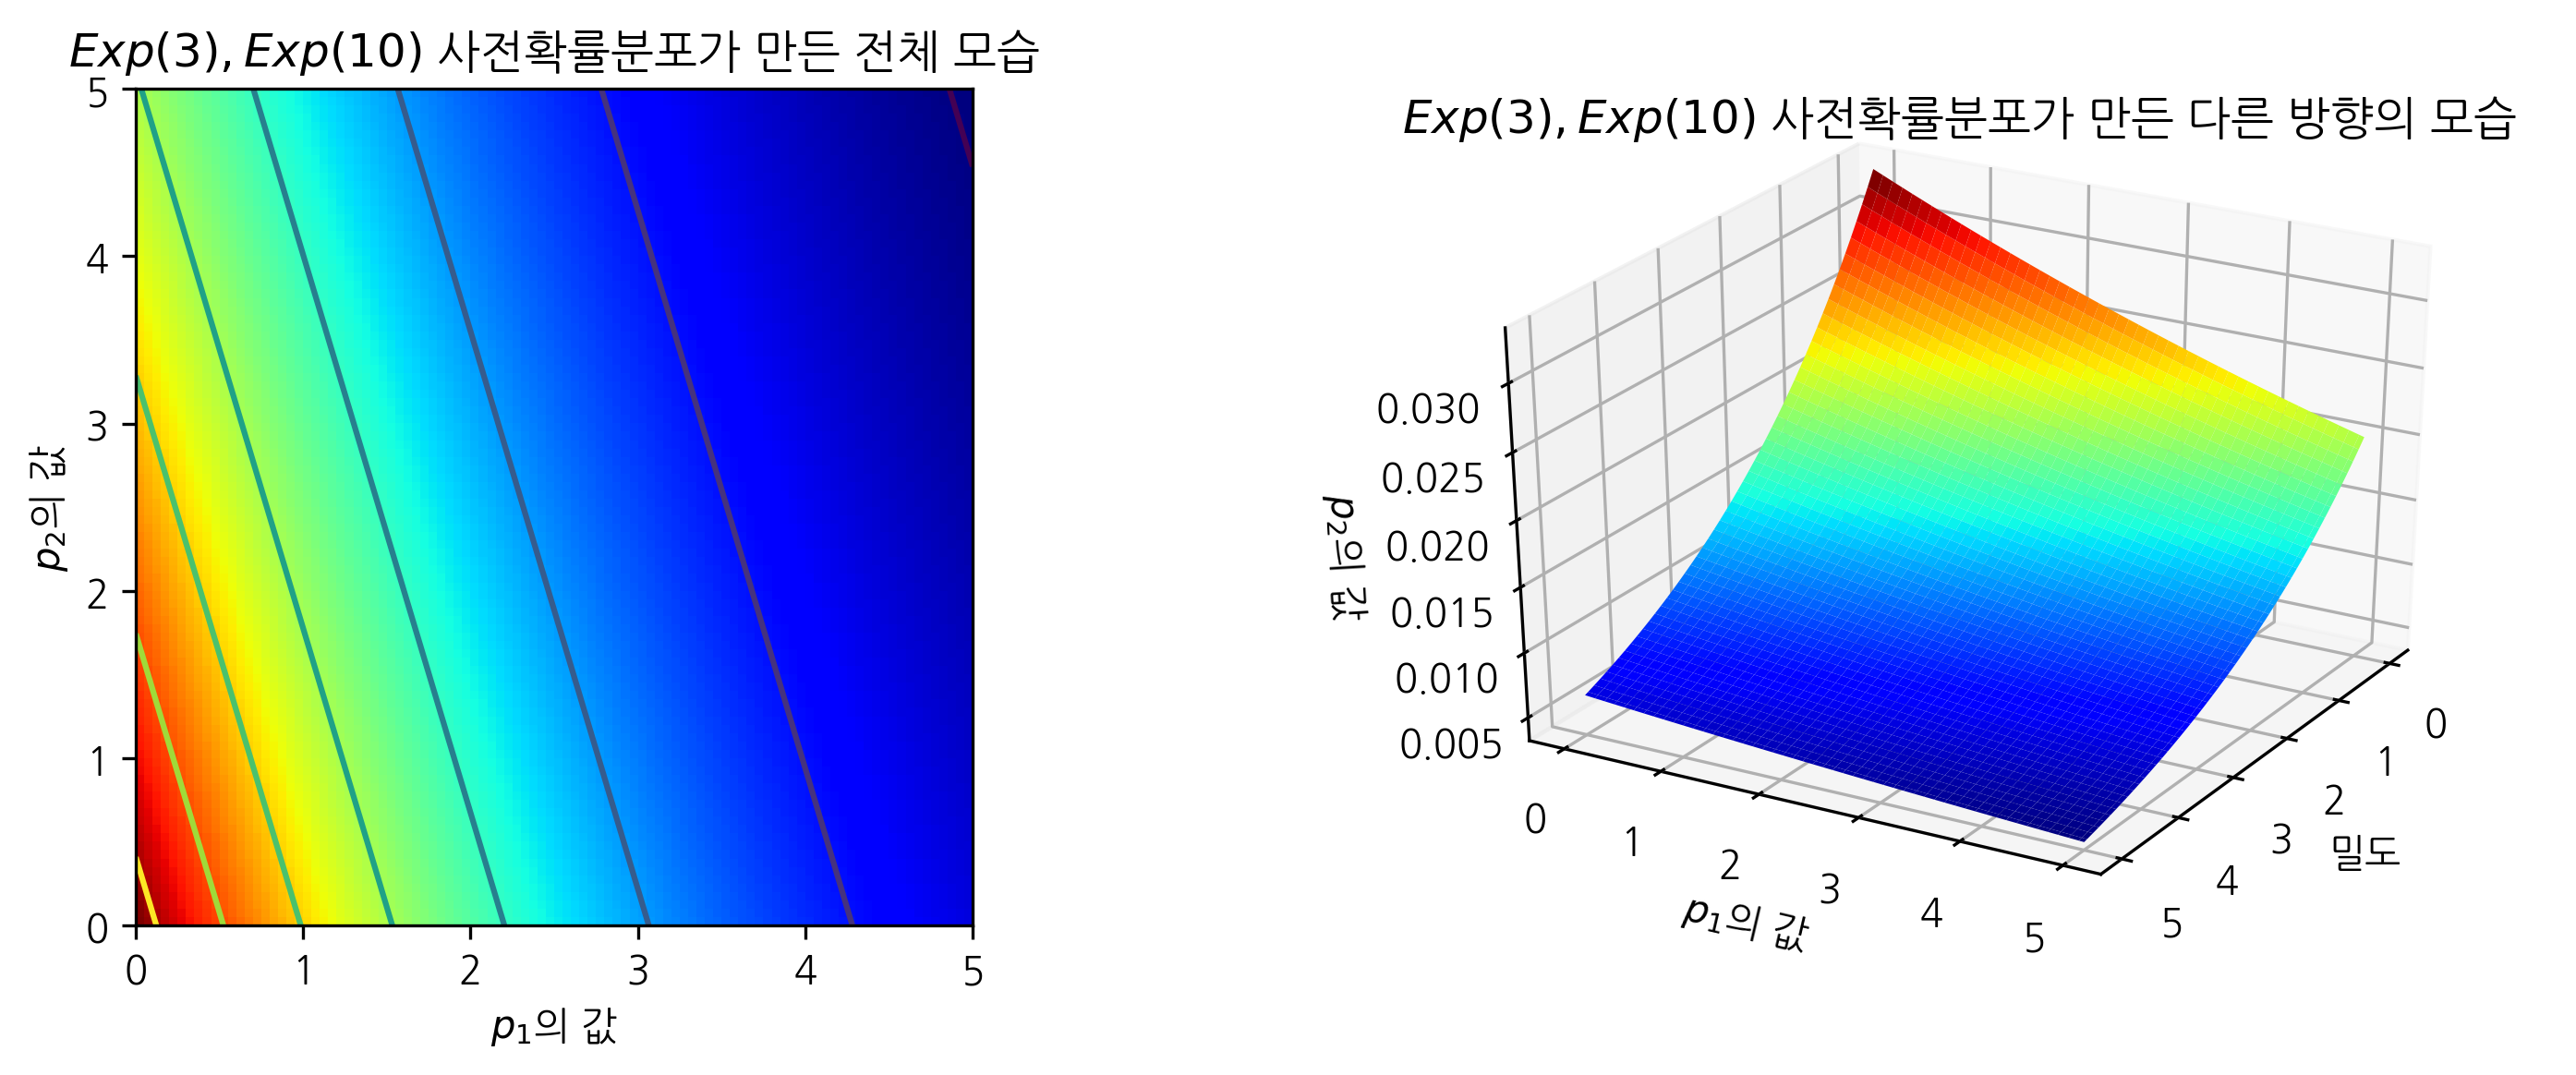

In [9]:
figsize(12, 4)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$Exp(3), Exp(10)$ 사전확률분포가 만든 전체 모습")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
ax.set_xlabel( "밀도" )
ax.set_ylabel( "$p_1$의 값" )
ax.set_zlabel( "$p_2$의 값" )
plt.title("$Exp(3), Exp(10)$ 사전확률분포가 만든 다른 방향의 모습");